## Extracting a calibrated 1d spectrum of a point source

Author: Tri L. Astraatmadja, tastraatmadja@stsci.edu

This note demonstrates a simple method to recover a calibrated 1d spectrum of a point source. We'll use `sncosmo` to generate the spectrum of a Type Ia Supernova (without the host-galaxy. Let's keep things simple for now) and put it in the center of a datacube, which we'll pass to the <i>Ilia</i> simulator to generate <i>Roman</i> 2d spectral image. We'll then try to recover the original input 1d spectrum from the observed 2d spectrum.

In [1]:
## pip install sncosmo

In [2]:
from astropy import units as u
from ilia.instrument.disperser import RomanPrism
from ilia.instrument.throughput import RomanEffectiveArea
from ilia.simulator import RomanDisperserSimulator
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import sncosmo
from scipy import constants as sciconsts
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler
from synphot import units

## Some plot settings
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize='large')
plt.rc('axes', labelsize='medium')

## Golden ratio
GOLDEN_RATIO = sciconsts.golden_ratio

In [3]:
## Define the wavelength grid to generate the supernova spectrum
waveMin    = 7000.00  * u.angstrom
waveMax    = 19040.00 * u.angstrom
nWaves     = 1 + 4 * 301
wavelength = np.linspace(waveMin, waveMax, nWaves, endpoint=True)

wavelength

<Quantity [ 7000.,  7010.,  7020., ..., 19020., 19030., 19040.] Angstrom>

In [4]:
## Generate the supernova spectrum using sncosmo

# redshift
redshift = 0.5

## SN time from maximum
t0 = 0.0

model = sncosmo.Model(source='hsiao')
model.set(z=redshift, t0=t0)
model.set_source_peakabsmag(-19.5, 'bessellv', 'ab')
for name in model.param_names:
    print(name, model[name])
print(model.bandmag('sdssz', 'ab', t0), model.bandflux('sdssz', t0))

sn_flux_flam    = model.flux(t0, wavelength.to_value(u.angstrom)) * units.FLAM
sn_flux_photlam = units.convert_flux(wavelength, sn_flux_flam, units.PHOTLAM)

z 0.5
t0 0.0
amplitude 7.836417804991638e-10
22.37681520385283 6.539716124861575e-05


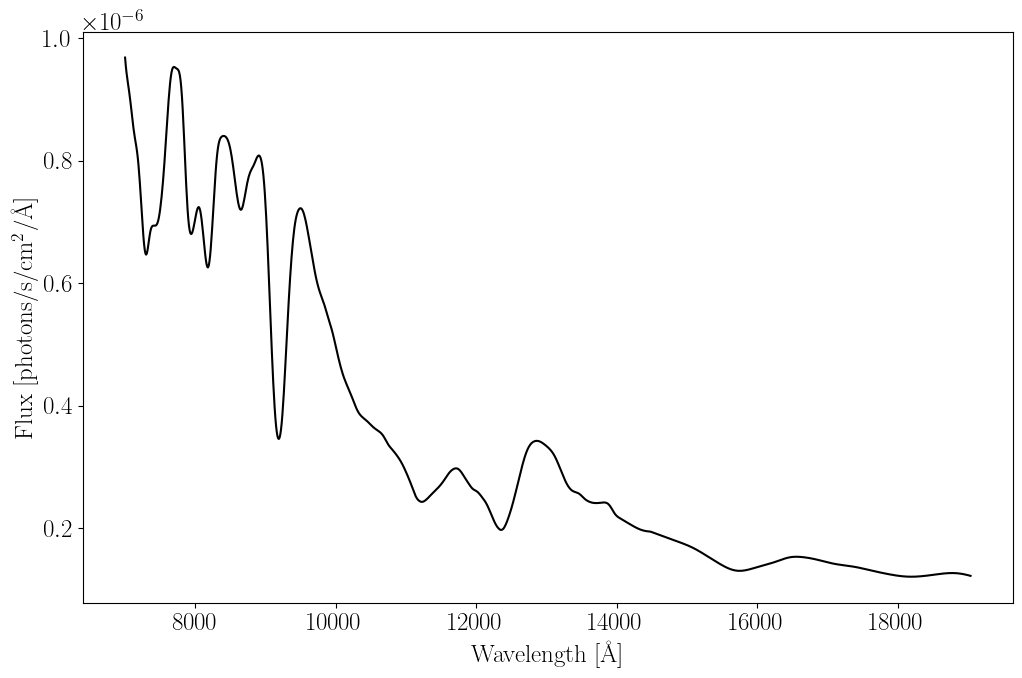

In [6]:
## Plot the spectrum, see if everything's alright
xSize = 12
ySize = xSize / GOLDEN_RATIO

fig = plt.figure(figsize=(xSize, ySize))

ax  = fig.add_subplot(111)

ax.plot(wavelength, sn_flux_photlam, 'k-')

ax.set_xlabel(r'Wavelength [\AA]')
ax.set_ylabel(r'Flux [photons/s/cm$^2$/\AA]');

In [7]:
## Constructing the datacube. We'll take it to be 51 x 51 Roman pixel and oversampled by a factor of 5
nPP, nQQ = 51, 51

oversample = 5

datacube = np.zeros((wavelength.size, nPP * oversample, nQQ * oversample)) * units.FLAM

nL, nP, nQ = datacube.shape

## Place the supernova spectrum in the center of the datacube
datacube[:,int(nP//2),int(nQ//2)] += sn_flux_flam

In [8]:
wavelength

<Quantity [ 7000.,  7010.,  7020., ..., 19020., 19030., 19040.] Angstrom>

In [9]:
datacube

<Quantity [[[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.]],

           [[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.]],

           [[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.]],

           ...,

           [[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
      

In [10]:
## Generate the observed 2d spectra

## Some parameters of the simulator
exposureTimeSp     = 1800.0 * u.s ## Exposure time for spectroscopic observations
addBackground      = False        ## No need to add background lights in the simulation
subtractBackground = True         ## Assume that the background lights have been properly subtracted.

## Dither pattern: shift_x, shift_y, and angle
ditherPattern = [(0.0, 0.0, 0.0)]

In [11]:
## Fire up the simulator and generate the spectrum using the parameters above
simulator = RomanDisperserSimulator(disperser='prism', oversample=oversample)
simResult = simulator.simulateSpectra(datacube, wavelength, dithers=ditherPattern, nJobs=16,
                                       addRandomDither=False, convolution='fft', exposureTime=exposureTimeSp, 
                                       addBackground=addBackground, subtractBackground=subtractBackground, includeIPC=False)

RESAMPLING SCENE TO PIXEL WAVELENGTH... DONE!
DITHER PATTERN 1/1: (0.000, 0.000, 0.000), FRACTIONAL PIXEL SHIFT: 0.000 pix
NEW_PSF_SHAPE: (509, 509, 1030)
USING DRIZZLE TO FORM SPECTRUM...


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    7.8s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   23.2s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   47.6s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  1.4min
[Parallel(n_jobs=16)]: Done 1030 out of 1030 | elapsed:  1.8min finished


DONE! ELAPSED TIME: 0 h 2 m 26.752 s
===== ALL DONE! Elapsed time: 0 h 6 m 2.779 s =====


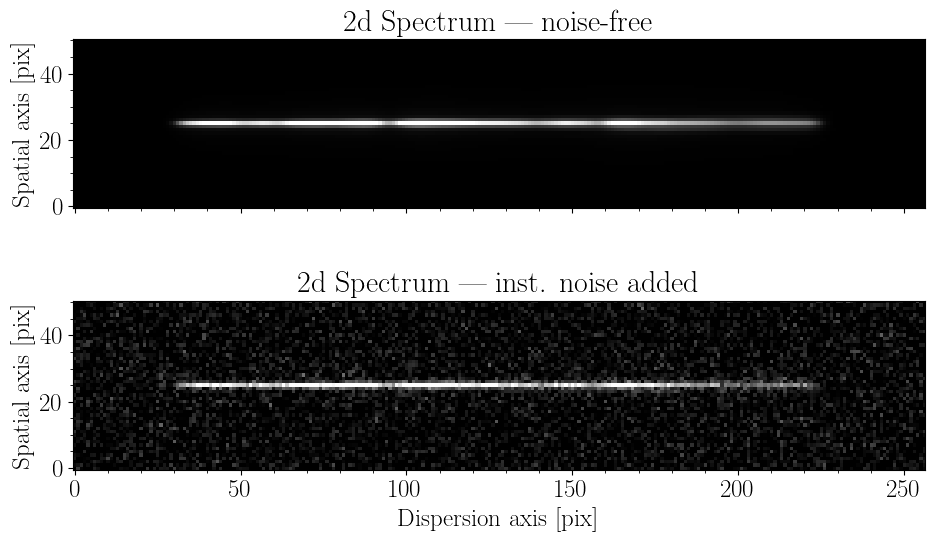

In [12]:
## Plot the 2d spectra images, the noise-free and the noisy data
nRows = 2
nCols = 1

xSize = 11
ySize = xSize/GOLDEN_RATIO

wspace = 0.00
hspace = 0.00

dX, dMX = 50, 10
dY, dMY = 20, 5

CI   = 99.0
P_HI = 0.5*(100.0 + CI)

fig, axes = plt.subplots(nRows, nCols, sharex=True, sharey=True, figsize=(xSize, ySize))

for k in range(nRows):
    ax = axes[k]

    if (k == 0):
        title = '2d Spectrum --- noise-free'
        image = simResult[0]['specRate'].value
    
    if (k == 1):
        title = '2d Spectrum --- inst. noise added'
        image = simResult[0]['noisySpec'].value
        
        ax.set_xlabel(r'Dispersion axis [pix]')
        
    vmin, vmax = 0.0, np.percentile(image, P_HI)

    ax.imshow(image, aspect='equal', cmap='gray', origin='lower', vmin=vmin, vmax=vmax, interpolation='nearest')
        
    ax.set_title(title)

    ax.xaxis.set_major_locator(MultipleLocator(dX))
    ax.xaxis.set_minor_locator(MultipleLocator(dMX))

    ax.yaxis.set_major_locator(MultipleLocator(dY))
    ax.yaxis.set_minor_locator(MultipleLocator(dMY))

    ax.set_ylabel(r'Spatial axis [pix]');

plt.subplots_adjust(wspace=wspace, hspace=hspace)

We are now going to extract the uncalibrated 1d spectrum from the 2d spectral image. Because this is a point source and this is a simulation of a postage stamp, we know exactly where the spectrum starts and ends, so we're going to cheat a bit here.

The trickier thing now is determining how many pixels over the vertical direction we're going to sum the spectrum. Too little then there's going to be too many flux losses due to PSF convolution. Too much then there's too much noise included. Ultimately we're probably do better using sophisticated technique like Optimum Spectral Extraction <a href="https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/abstract">(Horne 1986)</a>, but we're not going to do that here and keep it simple.

Here we're going to define `dK` which is how many pixels above and below the central row (the row containing most of the spectrum) we're going to sum the light. `dK = 2` means we're summing 5 pixels along the spatial axis, centered on the central row.

25 25


Text(0, 0.5, 'Count [ADU]')

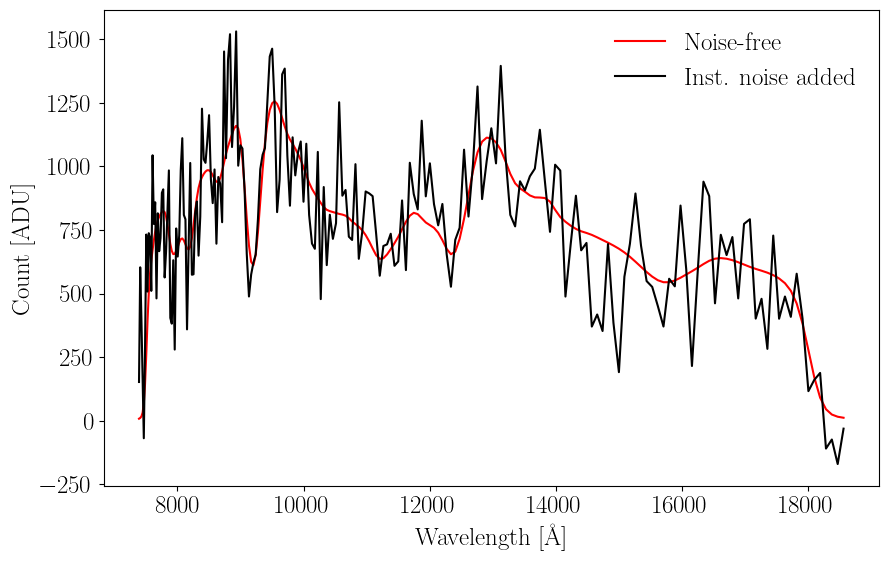

In [44]:
## Extract 1d spectrum from the 2d spectral image and plot it

xSize = 10
ySize = xSize / GOLDEN_RATIO

fig = plt.figure(figsize=(xSize, ySize))

ax = plt.subplot(111)

dX, dMX = 50, 10
dY, dMY = 1000, 200

noiseFreeSpec = simResult[0]['specRate'] * exposureTimeSp
noisySpec     = simResult[0]['noisySpec']
waveSpec      = simResult[0]['wavelength'].to(u.angstrom)

## We know already where the point source is located, based on where we put it in the datacube.
## We're going to cheat a bit and use it.

ySN, xSN = int(nPP // 2), int(nQQ // 2)

print(xSN, ySN)

## Define how many pixels up and above we want to extract the 1d spectrum. dK = 2 means we are taking 5 pixels along the vertical axis
dK    = 5
yyMin = max(ySN-dK, 0) ## Inclusive
yyMax = min(ySN+dK+1, noiseFreeSpec.shape[0]) ## EXCLUSIVE. So add an additional 1 pixel

## Along the dispersion axis, we start from where the object is located and for the number of wavelength in the image.
xxMin = xSN
xxMax = xxMin + waveSpec.size

spec1dNoiseFree = noiseFreeSpec[yyMin:yyMax, xxMin:xxMax].sum(0)
spec1dNoisy     = noisySpec[yyMin:yyMax, xxMin:xxMax].sum(0)

## Because this is a point source, we can use the wavelength scale without fear of contamination from neighboring pixel
ax.plot(waveSpec, spec1dNoiseFree, color='r', label='Noise-free')
ax.plot(waveSpec, spec1dNoisy, color='k', label='Inst. noise added')

ax.legend(frameon=False, loc='best')

ax.set_xlabel(r'Wavelength [\AA]')
ax.set_ylabel(r'Count [ADU]')

Now from the uncalibrated 1d spectrum, we're going to extract the 1d calibrated spectrum. Again we're going to keep it simple. In a given pixel $i$, the calibrated flux $f(\lambda_i)$ is
\begin{equation}
    f(\lambda_i) = \frac{I_i}{t_{\rm exp}A_{\rm eff}(\lambda_i)\left.\frac{d\lambda}{d\kappa_i}\right|_{\lambda_i}},
\end{equation}
where $I_i$ is the measured count at $i$, $A_{\rm eff}(\lambda_i)$ is the telescope effective area at wavelength $\lambda_i$ ($i$-th pixel corresponds to wavelength), and $d\lambda/d\kappa_i$ is the spectral sampling at wavelength $\lambda_i$

In [45]:
AEff  = RomanEffectiveArea()
prism = RomanPrism(oversample=1)

In [46]:
effArea    = AEff.getEffectiveArea(waveSpec, 'prism')
dispersion = prism.getDispersionCurve().to(u.angstrom / u.pix)

In [47]:
dispersion

<Quantity [18.62448581, 18.78985742, 18.95522903, 19.12060064, 19.28597225,
           19.45303644, 19.62522772, 19.797419  , 19.96961027, 20.14180155,
           20.31550655, 20.49510415, 20.67470175, 20.85429935, 21.03389695,
           21.21632013, 21.40358403, 21.59084793, 21.77811183, 21.96537573,
           22.15807841, 22.35278524, 22.54749208, 22.74219891, 22.93899454,
           23.14441056, 23.35407433, 23.5637381 , 23.77340187, 23.99088748,
           24.2085329 , 24.42617833, 24.64382375, 24.8688458 , 25.10192801,
           25.33501022, 25.56809243, 25.8085338 , 26.05011703, 26.29170026,
           26.53349776, 26.78590343, 27.04343498, 27.30096652, 27.56135984,
           27.82789032, 28.09442081, 28.36095129, 28.63466197, 28.9178592 ,
           29.20105644, 29.48687634, 29.7795649 , 30.07225347, 30.36494203,
           30.66865706, 30.97807576, 31.28749446, 31.60375146, 31.92310801,
           32.24246456, 32.56743497, 32.90320233, 33.23936003, 33.58076464,
           3

In [48]:
spec1dNoisy / exposureTimeSp / effArea / dispersion

<Quantity [ 2.38171086e-03,  8.61562038e-04,  7.39185995e-05,
            5.92152149e-06, -7.19244135e-07,  1.15453794e-06,
            1.63413627e-06,  7.91957916e-07,  9.68658123e-07,
            8.82539928e-07,  6.09928534e-07,  1.22708784e-06,
            8.96194586e-07,  9.80927251e-07,  5.41310139e-07,
            9.05432583e-07,  7.29918301e-07,  7.76110591e-07,
            9.56460114e-07,  9.60925020e-07,  5.88586830e-07,
            6.87674078e-07,  8.44739097e-07,  9.99784211e-07,
            4.06823975e-07,  3.80702882e-07,  6.23861010e-07,
            2.73845946e-07,  7.33774148e-07,  6.20044175e-07,
            6.92615197e-07,  9.26378805e-07,  1.03243876e-06,
            7.42771917e-07,  7.18787036e-07,  3.21821809e-07,
            5.95517386e-07,  8.86966263e-07,  4.96077633e-07,
            4.91798563e-07,  6.89175242e-07,  7.20580976e-07,
            5.36491610e-07,  6.56370600e-07,  9.92056756e-07,
            8.21393494e-07,  8.01195600e-07,  8.57540900e-07,
        

In [49]:
effArea

<Quantity [1.90410605e+00, 2.06985452e+01, 1.58951020e+02, 8.01787983e+02,
           2.77257889e+03, 6.86324471e+03, 1.26812407e+04, 1.79915192e+04,
           2.11762770e+04, 2.24670306e+04, 2.28848002e+04, 2.30578290e+04,
           2.31970657e+04, 2.33250870e+04, 2.34618215e+04, 2.35867088e+04,
           2.37052002e+04, 2.38114964e+04, 2.39016338e+04, 2.39497106e+04,
           2.39904878e+04, 2.40131606e+04, 2.40362196e+04, 2.40500000e+04,
           2.40521488e+04, 2.40560787e+04, 2.40580408e+04, 2.40724897e+04,
           2.40778600e+04, 2.41059389e+04, 2.41519793e+04, 2.42089982e+04,
           2.42601214e+04, 2.43313189e+04, 2.43917041e+04, 2.44636801e+04,
           2.45329032e+04, 2.45978615e+04, 2.46715647e+04, 2.47365830e+04,
           2.47799199e+04, 2.48176930e+04, 2.48540042e+04, 2.48889193e+04,
           2.49317600e+04, 2.49805250e+04, 2.50283452e+04, 2.50893015e+04,
           2.51642637e+04, 2.52626450e+04, 2.53541709e+04, 2.54622339e+04,
           2.55749111e+04

In [50]:
spec1d_cal_noiseFree = (spec1dNoiseFree / exposureTimeSp / effArea / dispersion).value * units.PHOTLAM
spec1d_cal_noisy     = (spec1dNoisy / exposureTimeSp / effArea / dispersion).value * units.PHOTLAM

In [51]:
## To compare between the extracted calibrated spectrum and the true supernova spectrum, we're going to resample 
## the true spectrum into the pixel wavelength grid of the observed spectrum. We're going to do it in a manner
## that conserves flux, using specutils.

flux_resampler = FluxConservingResampler()

true1dSpec = Spectrum1D(flux=sn_flux_flam, spectral_axis=wavelength)

true1dSpec_resampled_flam = flux_resampler(true1dSpec, waveSpec)

true1dSpec_resampled = Spectrum1D(flux=units.convert_flux(waveSpec, true1dSpec_resampled_flam.flux, units.PHOTLAM),
                                  spectral_axis=waveSpec)

In [42]:
true1dSpec_resampled.flux

<Quantity [6.93034071e-07, 6.93899974e-07, 6.93935169e-07, 6.95181530e-07,
           6.99802326e-07, 7.09666448e-07, 7.25421558e-07, 7.46521900e-07,
           7.72577229e-07, 8.03336040e-07, 8.37822082e-07, 8.73829854e-07,
           9.06747773e-07, 9.31617939e-07, 9.46573129e-07, 9.52256822e-07,
           9.52140190e-07, 9.50478219e-07, 9.48477634e-07, 9.42084147e-07,
           9.22691804e-07, 8.86177728e-07, 8.34727202e-07, 7.78178046e-07,
           7.26688919e-07, 6.95091538e-07, 6.81726355e-07, 6.83019528e-07,
           6.93426943e-07, 7.07643057e-07, 7.20071326e-07, 7.23441643e-07,
           7.13588856e-07, 6.92185671e-07, 6.62908613e-07, 6.38139045e-07,
           6.26665920e-07, 6.37076145e-07, 6.70917261e-07, 7.17463389e-07,
           7.66106883e-07, 8.05635745e-07, 8.27686702e-07, 8.36961377e-07,
           8.39797086e-07, 8.39829082e-07, 8.37092582e-07, 8.30125975e-07,
           8.17181210e-07, 7.97281912e-07, 7.72225213e-07, 7.47220851e-07,
           7.28009238e-07

<Figure size 1200x889.969 with 0 Axes>

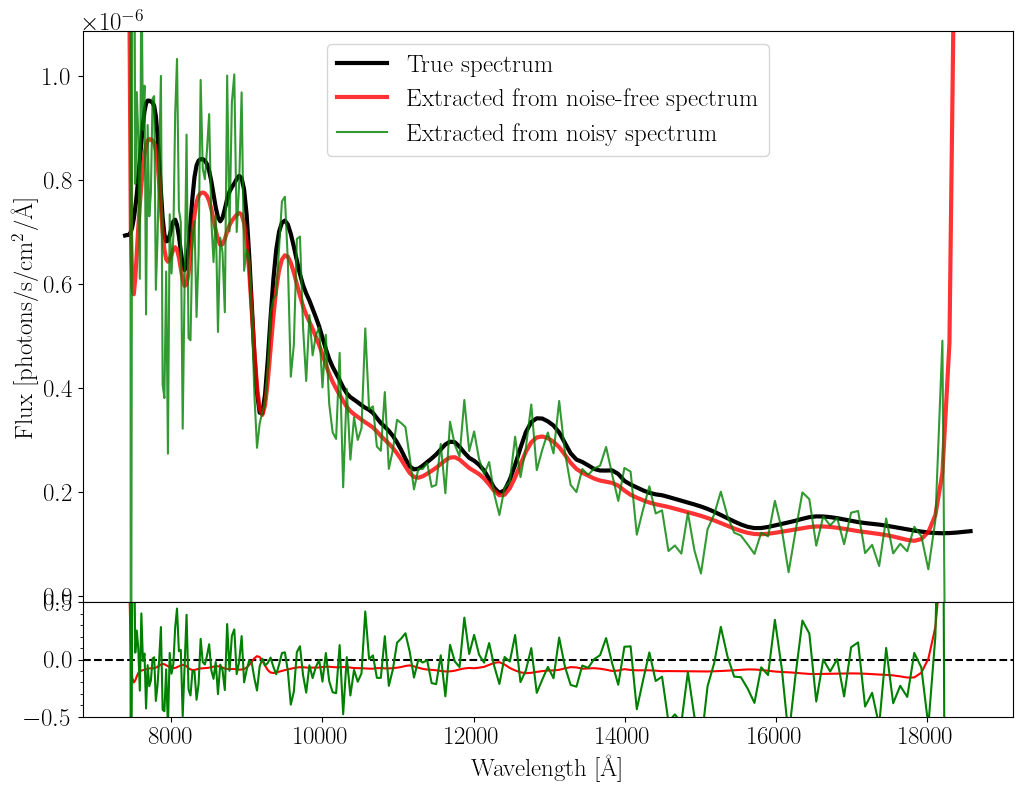

In [55]:
nRows = 2
nCols = 1

xSize = 12
ySize = 1.2 * xSize / GOLDEN_RATIO

alpha = 0.7

fig = plt.figure(figsize=(xSize, ySize))

fig, axes = plt.subplots(nRows, nCols, sharex=True, sharey=False, figsize=(xSize, ySize), height_ratios=[1.0, 0.2])

axes[0].plot(waveSpec, true1dSpec_resampled.flux, 'k-', label='True spectrum', linewidth=3)

yMin, yMax = axes[0].get_ylim()

axes[0].plot(waveSpec, spec1d_cal_noiseFree, 'r-', label='Extracted from noise-free spectrum', alpha=0.8, linewidth=3)

axes[0].plot(waveSpec, spec1d_cal_noisy, 'g-', label='Extracted from noisy spectrum', alpha=0.8)

axes[0].legend()

extend    = 0.1
axisRange = yMax - yMin 

axes[0].set_ylim(yMin - extend * axisRange, yMax + extend * axisRange)

## axes[0].set_ylim(0.8e-6, 1.2e-6)

axes[0].set_ylabel(r'Flux [photons/s/cm$^2$/\AA]')

axes[1].set_xlabel(r'Wavelength [\AA]')

fracRes_noiseFree = (spec1d_cal_noiseFree - true1dSpec_resampled.flux) / true1dSpec_resampled.flux
fracRes_noisy     = (spec1d_cal_noisy - true1dSpec_resampled.flux) / true1dSpec_resampled.flux

fracResRange = 0.5

dY, dMY = 0.5, 0.1

axes[1].axhline(linestyle='--', color='k')
axes[1].plot(waveSpec, fracRes_noiseFree, 'r-')
axes[1].plot(waveSpec, fracRes_noisy, 'g-')

axes[1].yaxis.set_major_locator(MultipleLocator(dY))
axes[1].yaxis.set_minor_locator(MultipleLocator(dMY))

axes[1].set_ylim(-fracResRange, +fracResRange)

plt.subplots_adjust(wspace=0.0, hspace=0.0)

There are still systematic residuals between the true and the extracted spectra. This is because we are not optimally extracting the 1d spectrum from the 2d spectral image. We can increase the `dK` parameter to reduce the systematic residuals, but we'll increase the noise. As mentioned previously, other methods exist to better do the job of extracting a 1d spectrum from a point source. This is a topic for another time.